# 1. Import the dependencies and pipeline modules

In [1]:
# 基础依赖
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pipeline各模块
from data_loader import DataLoader
from data_preprocessor import DataPreprocessor
from feature_selector import FeatureSelector
from model_trainer import ModelTrainer
from pipeline_config import MODEL_CONFIG

# 2. Data loading and display

In [2]:
# ===============================================================
#          步骤 1: 原始数据加载与快速预览
# ===============================================================
from data_loader import DataLoader

loader = DataLoader()
print("🔄 正在加载原始数据...")
raw_data = loader.merge_data() 

print(f"📊 原始数据维度: {raw_data.shape}")
print("\\n📋 原始数据预览:")
display(raw_data.head())

INFO:data_loader:Merging all data tables...
INFO:data_loader:Loading diabetic data...


🔄 正在加载原始数据...


INFO:data_loader:Diabetic data loaded: (101766, 50)
INFO:data_loader:Loading ID mapping data...
INFO:data_loader:ID mapping data loaded: (67, 2)
INFO:data_loader:ID mapping data split into three tables
INFO:data_loader:Data merged successfully: (101766, 51)


📊 原始数据维度: (101766, 51)
\n📋 原始数据预览:


,encounter_id,patient_nbr,race,gender,age,weight,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,25,1,?,Pediatrics-Endocrinology,...,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,3,?,?,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,2,?,?,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,1,2,?,?,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,?,?,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


## 2.1 保留首次入院记录

为了准确预测首次30天内再入院，我们只保留每个患者的第一次入院记录。这可以防止同一患者的多次再入院记录对模型产生偏见。后续的所有分析都将基于这个筛选后的数据集。

In [3]:
print(f"处理前总记录数: {len(raw_data)}")
print(f"处理前独立患者数: {raw_data['patient_nbr'].nunique()}")

# 按encounter_id排序，确保第一次入院记录在前
df_sorted = raw_data.sort_values(by='encounter_id')

# 删除重复的患者记录，只保留第一次
# 注意：我们将结果重新赋值给raw_data，以便后续单元格使用筛选后的数据
raw_data = df_sorted.drop_duplicates(subset='patient_nbr', keep='first')

print(f"\n处理后总记录数: {len(raw_data)}")
print(f"处理后独立患者数: {raw_data['patient_nbr'].nunique()}")

处理前总记录数: 101766
处理前独立患者数: 71518

处理后总记录数: 71518
处理后独立患者数: 71518


## 2.2 移除逻辑上无法再入院的患者

根据数据集的说明，部分 `discharge_disposition_id` 代表患者已经去世或被送往临终关怀机构，这些患者在生理上不可能再次入院。为了避免模型产生偏见，我们需要将这些记录移除。

In [4]:
# 定义代表去世或临终关怀的ID
hospice_or_death_ids = [11, 13, 14, 19, 20, 21]

print(f"处理前记录数: {len(raw_data)}")

# 筛选出不包含这些ID的记录
raw_data = raw_data[~raw_data['discharge_disposition_id'].isin(hospice_or_death_ids)]

print(f"移除不可能再入院的患者后，剩余记录数: {len(raw_data)}")

处理前记录数: 71518
移除不可能再入院的患者后，剩余记录数: 69973


# 3. Data Preprocessing and EDA

In [5]:
preprocessor = DataPreprocessor()
df = preprocessor.apply_feature_engineering(raw_data)
df = preprocessor.prepare_target_variable(df)
# 仅2个合并症
df =df[df['comorbidity'] == 2]
print(f"敏感性分析后数据量: {df.shape}")
print(f"特征工程后数据维度: {df.shape}")
display(df.head())

INFO:data_preprocessor:Applying feature engineering...
INFO:data_preprocessor:Original number of encounters: 69973
INFO:data_preprocessor:Encounters after keeping first admission: 69973
INFO:data_preprocessor:Removed 0 records for hospice/death dispositions.
INFO:data_preprocessor:Encounters after removing hospice/death: 69973
INFO:data_preprocessor:Handling missing values based on notebook's standard...
INFO:data_preprocessor:Replaced '?' with NaN.
INFO:data_preprocessor:🔴 Dropped columns with >50.0% missing: ['weight', 'max_glu_serum', 'A1Cresult']
INFO:data_preprocessor:🟡 Filling specified columns with 'Unknown': ['medical_specialty', 'payer_code', 'race', 'diag_1', 'diag_2', 'diag_3', 'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc']
INFO:data_preprocessor:✅ All missing values have been handled successfully.
INFO:data_preprocessor:Creating age-related features...
INFO:data_preprocessor:Creating diagnosis-related features...
INFO:data_preprocessor:Creatin

敏感性分析后数据量: (66542, 56)
特征工程后数据维度: (66542, 56)


,encounter_id,patient_nbr,race,gender,age,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,discharge_disposition_desc,admission_source_desc,age_midpoint,age_group,diag_1_category,diag_2_category,diag_3_category,comorbidity,encounter_index,readmitted_binary
8,12522,48330783,Caucasian,Female,[80-90),1,13,Unknown,Unknown,68,...,Discharged to home,Transfer from a hospital,125,80-90,circulatory,circulatory,other,2,1,0
9,15738,63555939,Caucasian,Female,[90-100),3,12,Unknown,InternalMedicine,33,...,Discharged/transferred to SNF,Transfer from a hospital,140,90-100,circulatory,neoplasms,respiratory,2,1,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,Unknown,Unknown,51,...,Discharged to home,Emergency Room,65,40-50,neoplasms,neoplasms,diabetes,2,1,0
10,28236,89869032,AfricanAmerican,Female,[40-50),1,9,Unknown,Unknown,47,...,Discharged to home,Emergency Room,65,40-50,diabetes,circulatory,injuries,2,1,0
5,35754,82637451,Caucasian,Male,[50-60),1,3,Unknown,Unknown,31,...,Discharged to home,Clinic Referral,80,50-60,circulatory,circulatory,diabetes,2,1,0


## 3.1 Missuing data handling

In [6]:
# 3.1 基础缺失值统计
print("=== 基础缺失值统计 ===")
missing_counts = raw_data.isnull().sum()
missing_percentage = (missing_counts / len(raw_data)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f"总共有 {len(missing_df)} 个列存在缺失值")
display(missing_df)

=== 基础缺失值统计 ===
总共有 5 个列存在缺失值


,Column,Missing_Count,Missing_Percentage
20,max_glu_serum,66625,95.215297
21,A1Cresult,57128,81.642919
50,admission_source_desc,4820,6.888371
48,admission_type_desc,4516,6.453918
49,discharge_disposition_desc,2474,3.535649


In [7]:
# 3.2 检查特殊字符 '?' 表示的缺失值
print("=== 特殊字符 '?' 统计 ===")
question_mark_counts = (raw_data == '?').sum()
question_mark_percentage = (question_mark_counts / len(raw_data)) * 100

question_mark_df = pd.DataFrame({
    'Column': question_mark_counts.index,
    'Question_Mark_Count': question_mark_counts.values,
    'Question_Mark_Percentage': question_mark_percentage.values
})
question_mark_df = question_mark_df[question_mark_df['Question_Mark_Count'] > 0].sort_values('Question_Mark_Percentage', ascending=False)

print(f"总共有 {len(question_mark_df)} 个列包含 '?' 字符")
display(question_mark_df)

=== 特殊字符 '?' 统计 ===
总共有 7 个列包含 '?' 字符


,Column,Question_Mark_Count,Question_Mark_Percentage
5,weight,67185,96.015606
9,medical_specialty,33639,48.074257
8,payer_code,30415,43.466766
2,race,1918,2.741057
18,diag_3,1224,1.749246
17,diag_2,293,0.418733
16,diag_1,10,0.014291


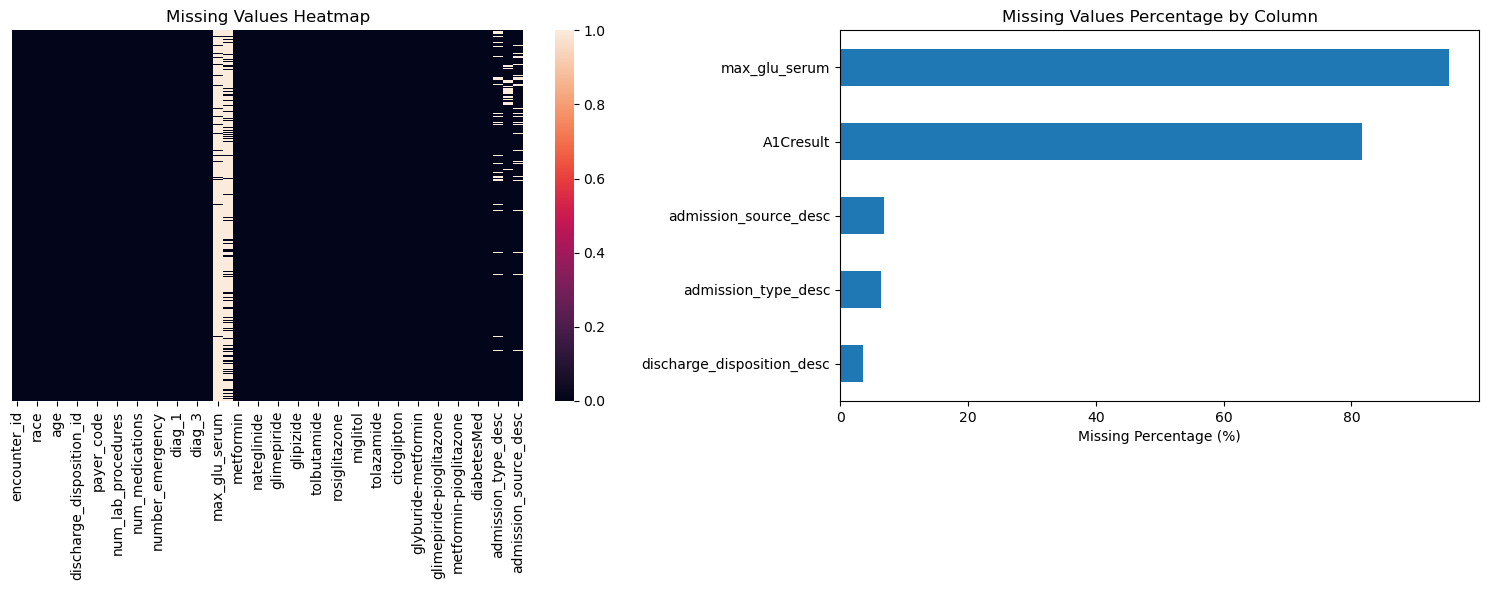

In [8]:
# 3.3 缺失值可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 缺失值热力图
missing_data = raw_data.isnull()
sns.heatmap(missing_data, cbar=True, yticklabels=False, ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# 缺失值百分比条形图
missing_percentage_sorted = missing_percentage[missing_percentage > 0].sort_values(ascending=True)
missing_percentage_sorted.plot(kind='barh', ax=axes[1])
axes[1].set_title('Missing Values Percentage by Column')
axes[1].set_xlabel('Missing Percentage (%)')

plt.tight_layout()
plt.show()

In [9]:
# 3.4 缺失值处理决策（与Pipeline逻辑完全一致）
print("=== 缺失值处理决策（与Pipeline逻辑一致） ===")
print("基于data_preprocessor.py中的处理标准，我们生成以下决策表：")
print()

# --- 为了准确分析，先模拟pipeline的第一步：将'?'替换为NaN ---
analysis_df = raw_data.replace('?', np.nan)
missing_percentage = (analysis_df.isnull().sum() / len(analysis_df)) * 100

# --- 定义与pipeline完全一致的阈值和填充列 ---
drop_missing_threshold = 50.0
cols_to_fill_with_unknown = [
    'medical_specialty', 'payer_code', 'race',
    'diag_1', 'diag_2', 'diag_3',
    'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc'
]

# --- 生成与pipeline行为一致的决策表 ---
decision_data = []
all_missing_cols_df = missing_percentage[missing_percentage > 0]

for col, percentage in all_missing_cols_df.items():
    if percentage > drop_missing_threshold:
        action = "删除"
        reason = f"缺失率 ({percentage:.1f}%) > {drop_missing_threshold}%"
    elif col in cols_to_fill_with_unknown:
        action = "保留, 用'Unknown'填充"
        reason = f"预定义的填充列"
    else:
        action = "保留, 未指定处理"
        reason = "缺失率低但未在填充列表中"

    decision_data.append([col, f"{percentage:.1f}%", action, reason])

decision_df = pd.DataFrame(decision_data, columns=['列名', '缺失率', '处理方式', '原因'])
decision_df = decision_df.sort_values('缺失率', ascending=False)

print("📋 缺失值处理决策表 (与Pipeline同步):")
display(decision_df)

=== 缺失值处理决策（与Pipeline逻辑一致） ===
基于data_preprocessor.py中的处理标准，我们生成以下决策表：

📋 缺失值处理决策表 (与Pipeline同步):


,列名,缺失率,处理方式,原因
1,weight,96.0%,删除,缺失率 (96.0%) > 50.0%
7,max_glu_serum,95.2%,删除,缺失率 (95.2%) > 50.0%
8,A1Cresult,81.6%,删除,缺失率 (81.6%) > 50.0%
11,admission_source_desc,6.9%,"保留, 用'Unknown'填充",预定义的填充列
9,admission_type_desc,6.5%,"保留, 用'Unknown'填充",预定义的填充列
3,medical_specialty,48.1%,"保留, 用'Unknown'填充",预定义的填充列
2,payer_code,43.5%,"保留, 用'Unknown'填充",预定义的填充列
10,discharge_disposition_desc,3.5%,"保留, 用'Unknown'填充",预定义的填充列
0,race,2.7%,"保留, 用'Unknown'填充",预定义的填充列
6,diag_3,1.7%,"保留, 用'Unknown'填充",预定义的填充列


## 3.2 EDA

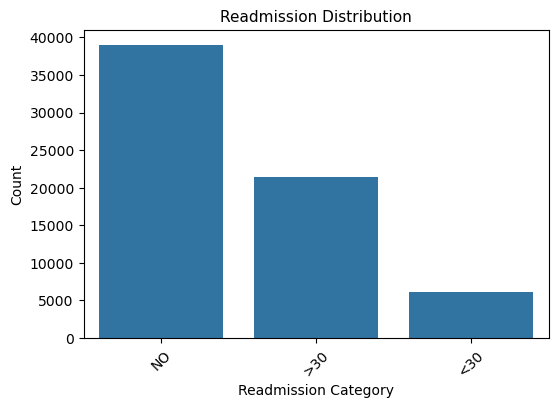

readmitted
NO     39030
>30    21422
<30     6090
Name: count, dtype: int64
No missing values found.
The average age of patients is: 96.79 years
Average stay at hospital by Age Group In Days
age_group
0-10      2.911765
10-20     3.475806
20-30     3.718510
30-40     3.793603
40-50     3.952480
50-60     4.047758
60-70     4.301429
70-80     4.548732
80-90     4.800568
90-100    4.827666
Name: time_in_hospital, dtype: float64


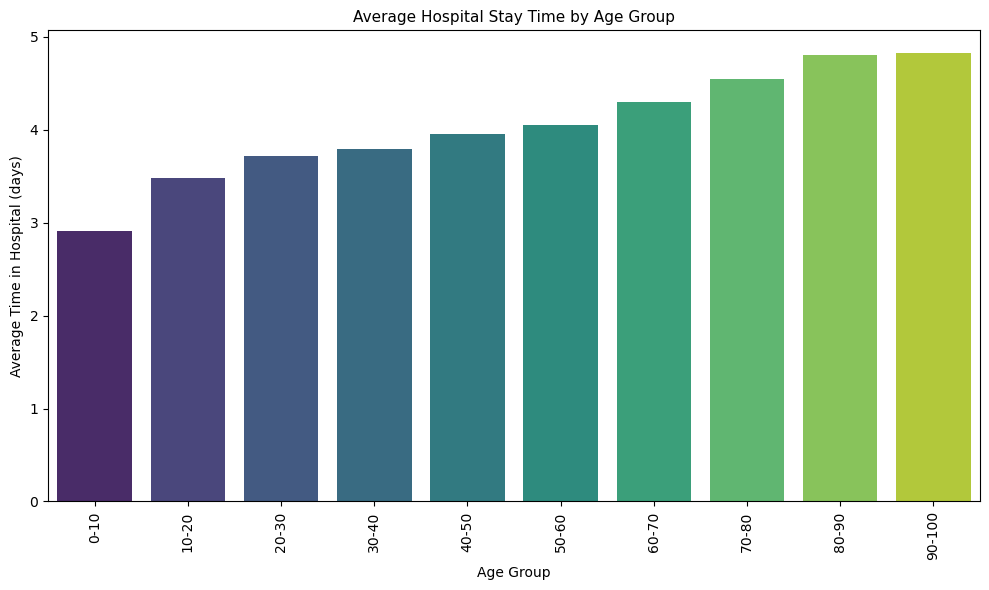

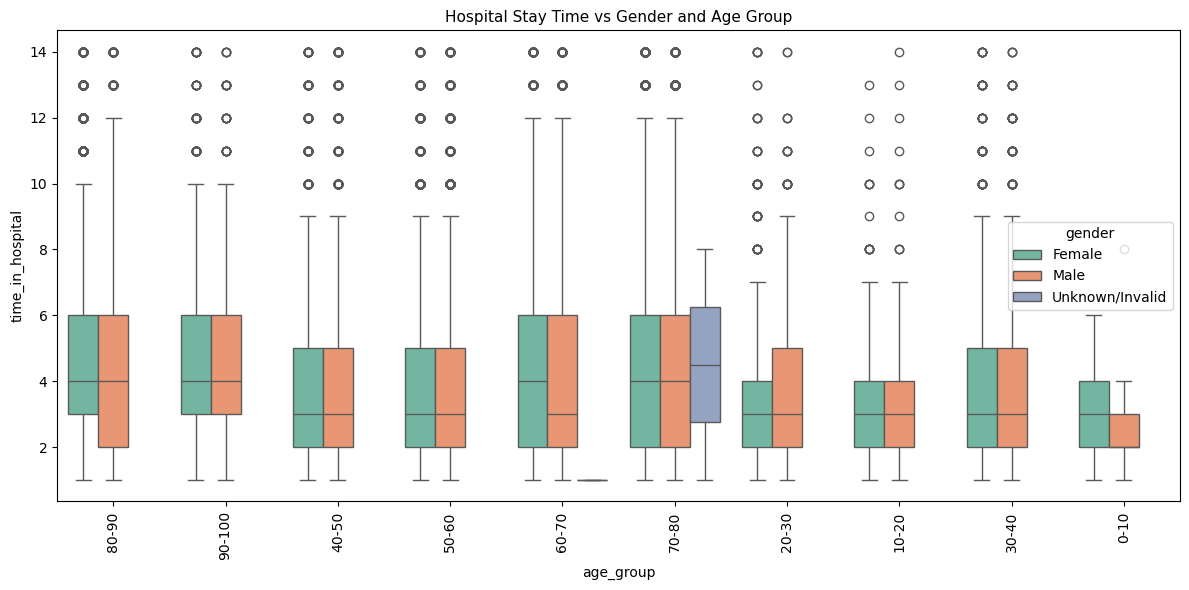

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


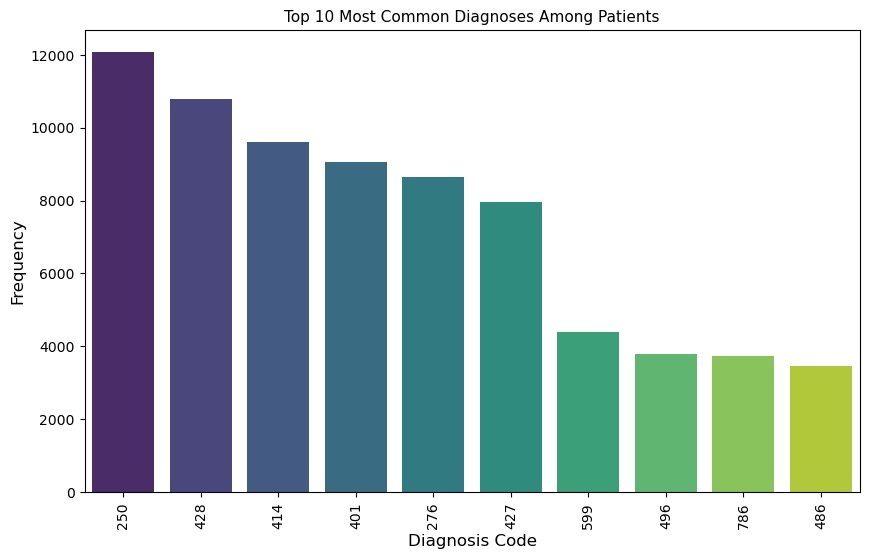

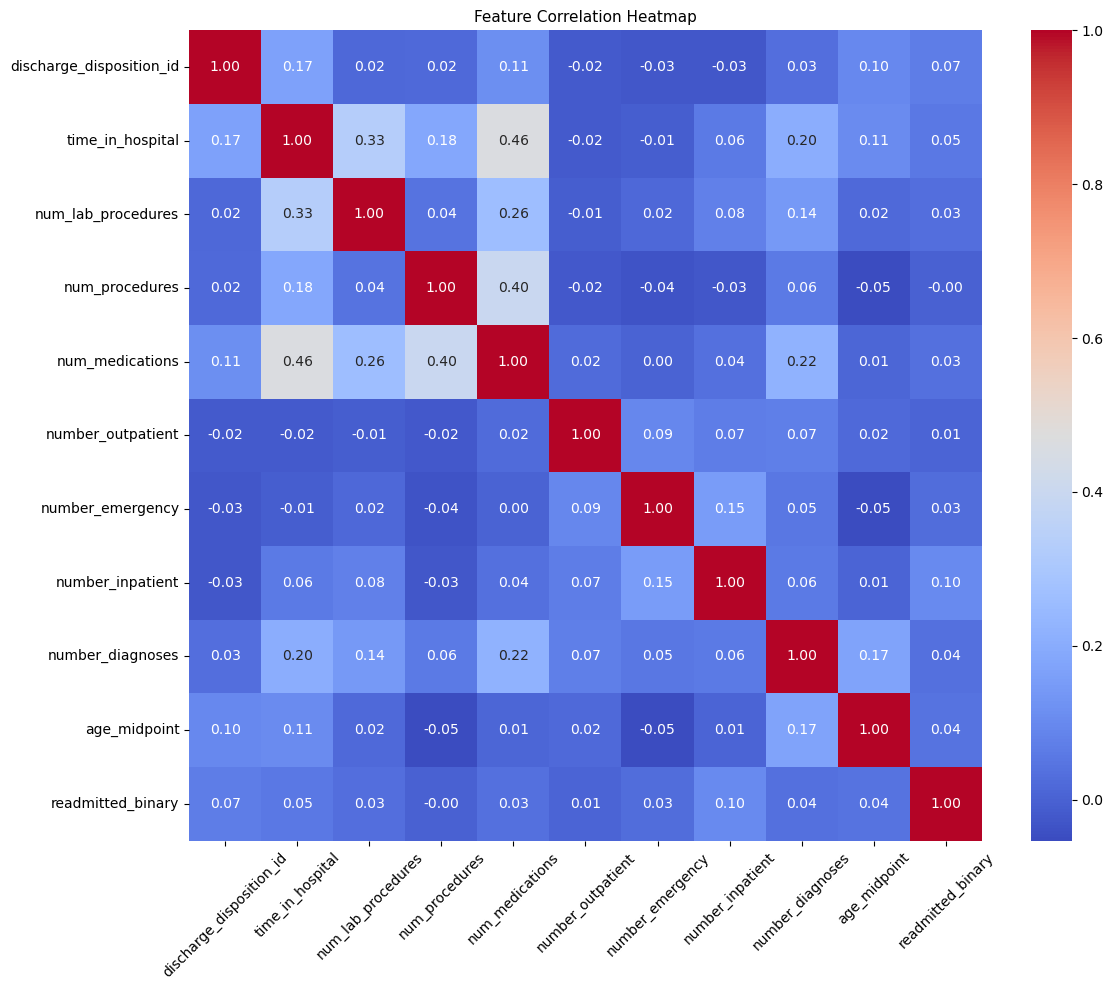

In [10]:
from eda_analyzer import EDAAnalyzer

# 选择你要分析的数据表
eda = EDAAnalyzer(df)  # 或 processed_data

# 1. readmission 分布
eda.plot_readmission_distribution()

# 2. 缺失值分布
eda.plot_missing_values()

# 1. 平均年龄
eda.plot_average_age()

# 2. 按年龄组画住院时长均值柱状图
eda.plot_avg_stay_by_age_group()

# 3. 按年龄组和性别画住院时长箱线图
eda.plot_avg_stay_by_age_gender_box()

# 4. 前10诊断分布
eda.plot_top_diagnoses_simple()

# 5. 特征相关性热力图
eda.plot_correlation_heatmap()


# 4. Medical interpretation

## 4.1 Readdmision rate with Age group & gender 

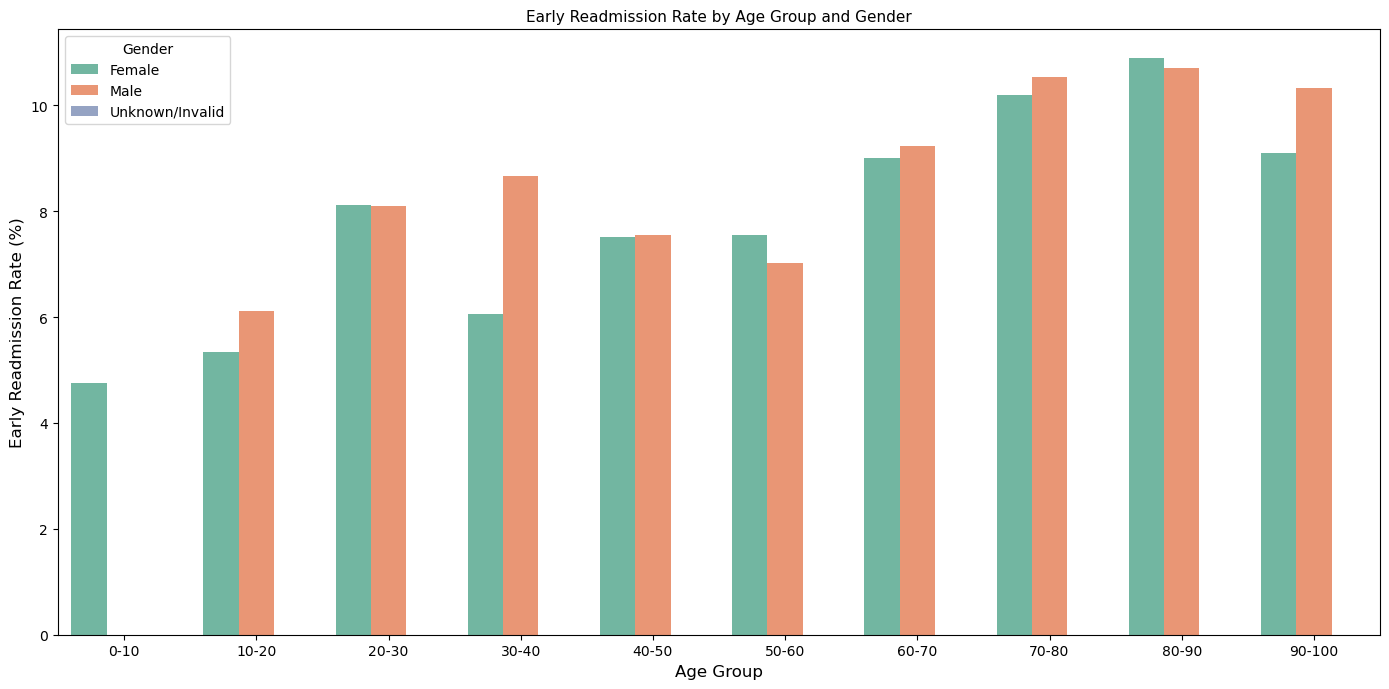

Readmission Rate Heatmap Table (age_group x gender_readmit):
gender_readmit  Early Readmission-Female  Early Readmission-Male  \
age_group                                                          
0-10                            2.941176                0.000000   
10-20                           3.225806                2.419355   
20-30                           5.366922                2.738226   
30-40                           3.582090                3.539446   
40-50                           3.699569                3.827141   
50-60                           3.671688                3.603218   
60-70                           4.398730                4.722847   
70-80                           5.469383                4.879037   
80-90                           6.659949                4.159033   
90-100                          6.455331                2.997118   

gender_readmit  No Early Readmission-Female  No Early Readmission-Male  
age_group                                        

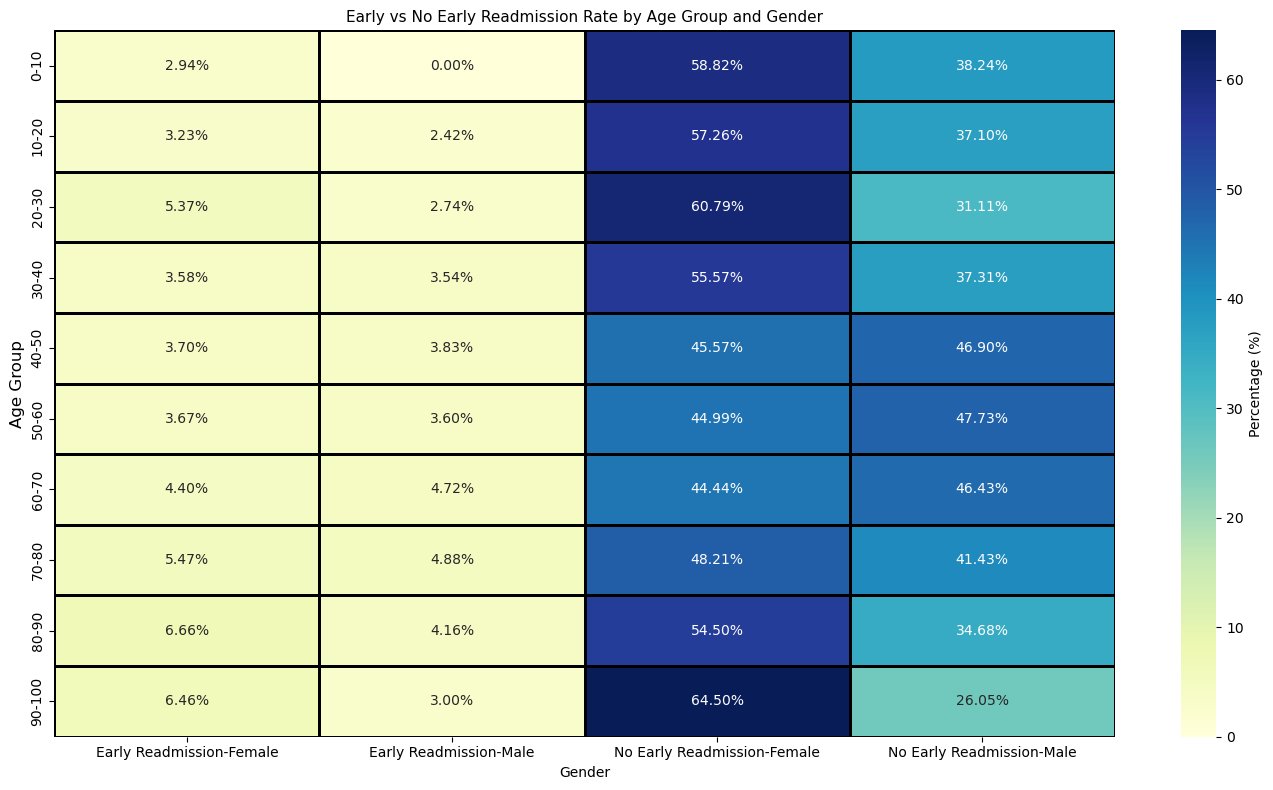

gender_readmit,Early Readmission-Female,Early Readmission-Male,No Early Readmission-Female,No Early Readmission-Male
age_group,,,,
0-10,2.941176,0.000000,58.823529,38.235294
10-20,3.225806,2.419355,57.258065,37.096774
20-30,5.366922,2.738226,60.788609,31.106243
30-40,3.582090,3.539446,55.565032,37.313433
40-50,3.699569,3.827141,45.574868,46.898421
50-60,3.671688,3.603218,44.993153,47.731941
60-70,4.398730,4.722847,44.437095,46.434714
70-80,5.469383,4.879037,48.205811,41.434194
80-90,6.659949,4.159033,54.497985,34.683034


In [11]:
# 统计并可视化不同年龄组和性别下的再入院率分布
eda.plot_readmission_rate_by_age_gender()

# 画age_group和gender下<30/>30 readmission rate的热力图
eda.plot_readmission_rate_heatmap_by_age_gender()



## 4.2  Relationship between comorbidities (e.g., diabetes, heart disease) and Readmission Rates

Readmission rate by comorbidity (%):
readmit_bin      Early Readmission Rate (%)  No Early Readmission Rate (%)
comorbidity                                                               
circulatory                        9.476498                      90.523502
diabetes                           9.180958                      90.819042
digestive                          8.631579                      91.368421
genitourinary                      8.844340                      91.155660
injuries                          10.245902                      89.754098
musculoskeletal                    8.342133                      91.657867
neoplasms                         12.928082                      87.071918
other                              8.361002                      91.638998
respiratory                        7.793675                      92.206325


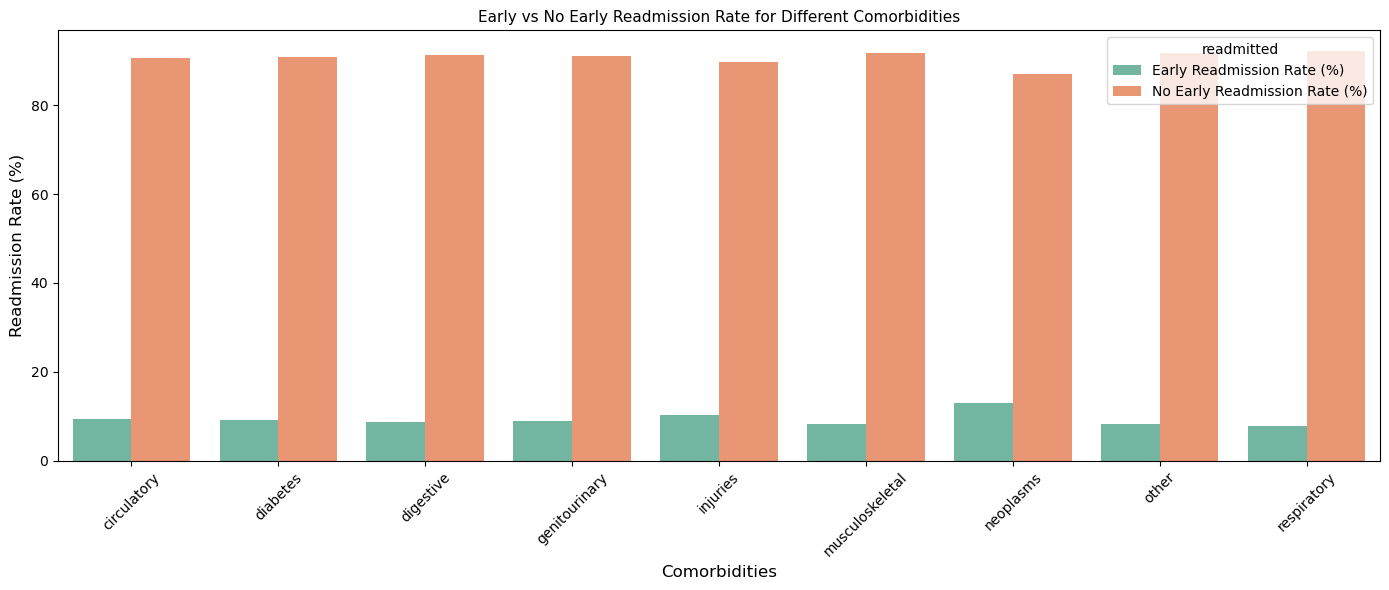

readmit_bin,comorbidity,Early Readmission Rate (%),No Early Readmission Rate (%)
0,circulatory,9.476498,90.523502
1,diabetes,9.180958,90.819042
2,digestive,8.631579,91.368421
3,genitourinary,8.844340,91.155660
4,injuries,10.245902,89.754098
5,musculoskeletal,8.342133,91.657867
6,neoplasms,12.928082,87.071918
7,other,8.361002,91.638998
8,respiratory,7.793675,92.206325


In [12]:
eda.plot_comorbidity_vs_readmission(preprocessor.icd9_to_nine_category)

## 4.3 Medication

Readmission Rate (<30 Days) by Medication & Dose Change:
readmitted           Medication Dose Change        <30
0                   glimepiride   Decreased  29.032258
1                   glimepiride   Increased  25.842697
2                   glimepiride   No Change  20.516605
3                   glimepiride   Not Given  22.191033
4                     glipizide   Decreased  25.274725
5                     glipizide   Increased  24.603175
6                     glipizide   No Change  21.715116
7                     glipizide   Not Given  22.146544
8           glipizide-metformin   No Change        NaN
9           glipizide-metformin   Not Given  22.139014
10                    glyburide   Decreased  20.855615
11                    glyburide   Increased  22.440945
12                    glyburide   No Change  22.423347
13                    glyburide   Not Given  22.110491
14          glyburide-metformin   Decreased        NaN
15          glyburide-metformin   Increased        NaN
16      

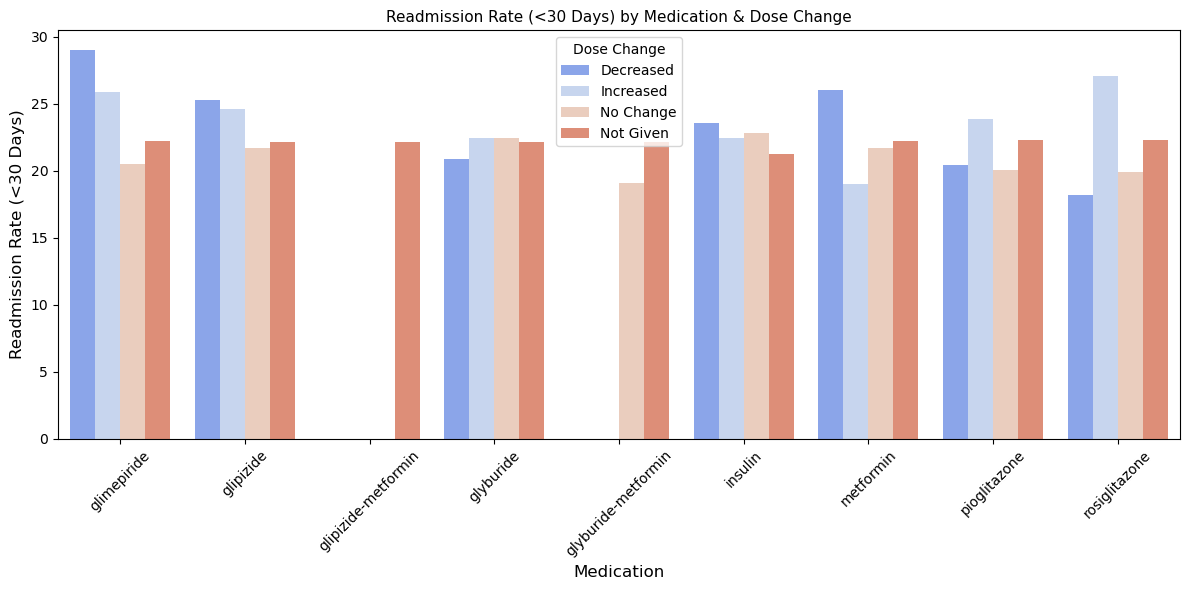

Readmission Rate (<30 Days) by Medication & Dose Change:
readmitted           Medication Dose Change        <30
0                   glimepiride   Decreased  29.032258
1                   glimepiride   Increased  25.842697
2                   glimepiride   No Change  20.516605
3                   glimepiride   Not Given  22.191033
4                     glipizide   Decreased  25.274725
5                     glipizide   Increased  24.603175
6                     glipizide   No Change  21.715116
7                     glipizide   Not Given  22.146544
8           glipizide-metformin   No Change        NaN
9           glipizide-metformin   Not Given  22.139014
10                    glyburide   Decreased  20.855615
11                    glyburide   Increased  22.440945
12                    glyburide   No Change  22.423347
13                    glyburide   Not Given  22.110491
14          glyburide-metformin   Decreased        NaN
15          glyburide-metformin   Increased        NaN
16      

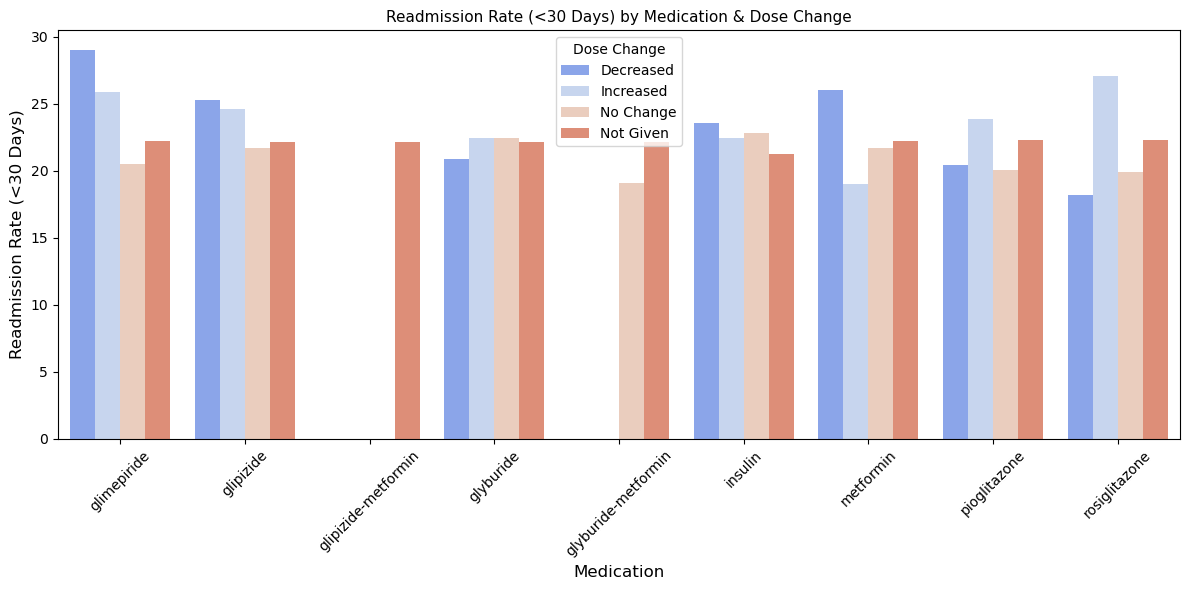

Readmission Rate (<30 Days) Heatmap Table:
Dose Change          Decreased  Increased  No Change  Not Given
Medication                                                     
glimepiride          29.032258  25.842697  20.516605  22.191033
glipizide            25.274725  24.603175  21.715116  22.146544
glipizide-metformin        NaN        NaN        NaN  22.139014
glyburide            20.855615  22.440945  22.423347  22.110491
glyburide-metformin        NaN        NaN  19.072165  22.155513
insulin              23.562677  22.425078  22.833080  21.254951
metformin            26.035503  18.983051  21.730502  22.240901
pioglitazone         20.454545  23.863636  20.057582  22.303922
rosiglitazone        18.181818  27.083333  19.876416  22.301961


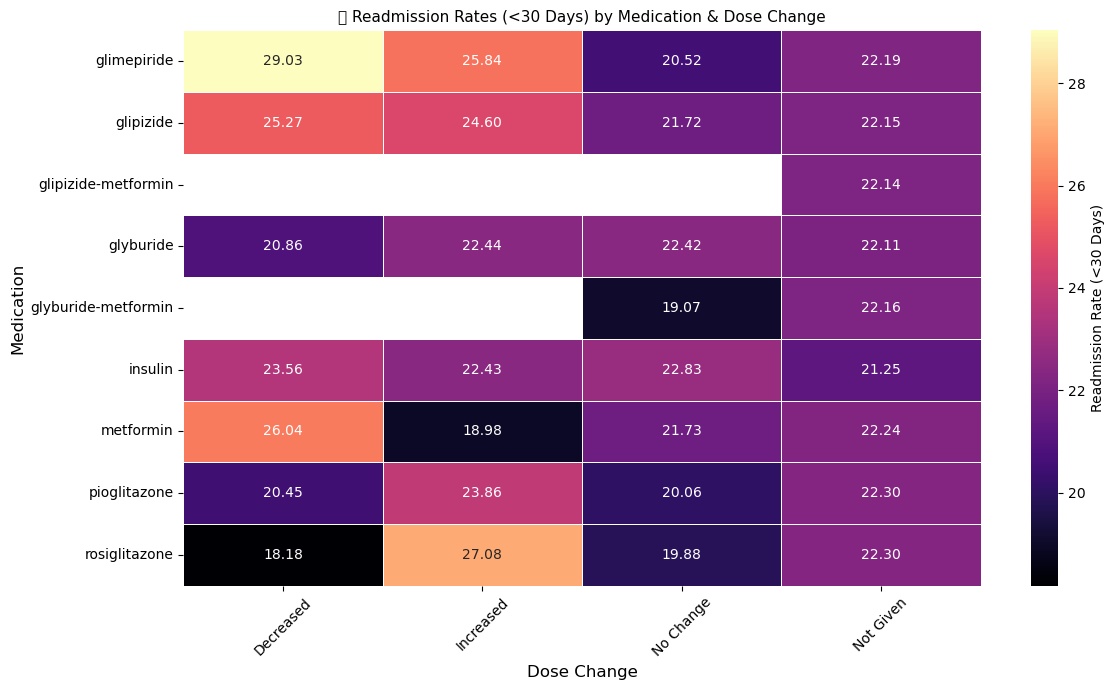

Dose Change,Decreased,Increased,No Change,Not Given
Medication,,,,
glimepiride,29.032258,25.842697,20.516605,22.191033
glipizide,25.274725,24.603175,21.715116,22.146544
glipizide-metformin,NaN,NaN,NaN,22.139014
glyburide,20.855615,22.440945,22.423347,22.110491
glyburide-metformin,NaN,NaN,19.072165,22.155513
insulin,23.562677,22.425078,22.833080,21.254951
metformin,26.035503,18.983051,21.730502,22.240901
pioglitazone,20.454545,23.863636,20.057582,22.303922
rosiglitazone,18.181818,27.083333,19.876416,22.301961


In [13]:


eda.plot_readmission_by_medication_and_dose()
# 热力图
eda.plot_readmission_by_medication_and_dose_heatmap()

# 5.Feature Engineering

## 5.1 Dataset division and encoding

In [14]:
# X_train, _, X_test, y_train, _, y_test = preprocessor.split_data(df)
# # 用X_test占位val参数
# X_train, _, X_test = preprocessor.encode_categorical_features(X_train, X_test, X_test)
# X_train, _, X_test = preprocessor.scale_numerical_features(X_train, X_test, X_test)

In [15]:
# 在建模前，drop 掉分组变量及其来源变量
drop_cols = ['comorbidity', 'number_diagnoses']

In [16]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(df)
X_train, X_val, X_test = preprocessor.encode_categorical_features(X_train, X_val, X_test)
X_train, X_val, X_test = preprocessor.scale_numerical_features(X_train, X_val, X_test)
X_train_balanced, y_train_balanced = preprocessor.apply_smote(X_train, y_train)
print(f'The number of samples in the training set after balancing: {X_train_balanced.shape[0]}')

INFO:data_preprocessor:Splitting data into train/validation/test sets...
INFO:data_preprocessor:Dropping unused ID and target columns before splitting: ['encounter_id', 'patient_nbr', 'discharge_disposition_id', 'readmitted']
INFO:data_preprocessor:Data split - Train: (42586, 51), Val: (10647, 51), Test: (13309, 51)
INFO:data_preprocessor:Encoding categorical features using label encoding...
INFO:data_preprocessor:Scaling numerical features...
INFO:data_preprocessor:Applying SMOTE for class balancing...
INFO:data_preprocessor:Before SMOTE - Class distribution: {0: 38688, 1: 3898}
INFO:data_preprocessor:After SMOTE - Class distribution: {0: 38688, 1: 38688}


The number of samples in the training set after balancing: 77376


## 5.2 Top_N Feature selection

In [17]:
# ===============================================================
#          多Top N值特征选择与结果展示
# ===============================================================

# 1. 设置您想要测试的top_n值列表
top_n_list = [ 5,10,15]  # 您可以随意修改这个列表
print(f"将要测试的Top N值: {top_n_list}")

# 2. 创建特征选择器
selector = FeatureSelector()

# 3. 运行多个top_n值的特征选择
print("\n🚀 开始运行多个Top N值的特征选择...")
multiple_results = selector.select_features_multiple_topn(
    X_train_balanced, 
    y_train_balanced, 
    top_n_list
)
print("✅ 特征选择完成！")


from feature_selector import flatten_multiple_results
selected_features_dict = flatten_multiple_results(multiple_results)

# 5. (可选) 选择一组特征进行后续步骤
#    您可以根据上面的表格结果，选择一组最满意的特征
#    例如，选择top_n=10时，L1方法选择的特征
# ---------------------------------------------------------------
# chosen_top_n = 10
# chosen_method = 'L1'
# X_selected = X_train_balanced[multiple_results[chosen_top_n][chosen_method]]
# print(f"\n proceeding with top_n={chosen_top_n} and method='{chosen_method}'")
# print(f"Selected {len(X_selected.columns)} features.")

INFO:feature_selector:Running feature selection with multiple top_n values: [5, 10, 15]
INFO:feature_selector:Processing top_n = 5
INFO:feature_selector:Running all feature selection methods with top_n=5...
INFO:feature_selector:Selecting top 5 features using L1 regularization...


将要测试的Top N值: [5, 10, 15]

🚀 开始运行多个Top N值的特征选择...


INFO:feature_selector:L1 feature selection completed. Selected features: ['number_inpatient', 'tolazamide', 'diabetesMed', 'age_group', 'num_procedures']
INFO:feature_selector:Selecting top 5 features using Mutual Information...
INFO:feature_selector:Mutual Information feature selection completed. Selected features: ['num_lab_procedures', 'num_medications', 'diag_2', 'diag_1', 'diag_3']
INFO:feature_selector:Selecting top 5 features using Tree-based importance...
INFO:feature_selector:Tree-based feature selection completed. Selected features: ['discharge_disposition_desc', 'num_procedures', 'age_midpoint', 'time_in_hospital', 'age']
INFO:feature_selector:All feature selection methods completed
INFO:feature_selector:Processing top_n = 10
INFO:feature_selector:Running all feature selection methods with top_n=10...
INFO:feature_selector:Selecting top 10 features using L1 regularization...
INFO:feature_selector:L1 feature selection completed. Selected features: ['number_inpatient', 'tolaza

✅ 特征选择完成！


## 5.3 Feature selection visualization


📊 Multiple Top N Value Feature Selection Detailed Results:


,Top N,Method,Selected Features
0,5,L1,"[number_inpatient, tolazamide, diabetesMed, age_group, num_procedures]"
1,5,MutualInfo,"[num_lab_procedures, num_medications, diag_2, diag_1, diag_3]"
2,5,TreeImportance,"[discharge_disposition_desc, num_procedures, age_midpoint, time_in_hospital, age]"
3,10,L1,"[number_inpatient, tolazamide, diabetesMed, age_group, num_procedures, payer_code, diag_1_catego..."
4,10,MutualInfo,"[num_lab_procedures, num_medications, diag_2, diag_1, diag_3, time_in_hospital, num_procedures, ..."
5,10,TreeImportance,"[discharge_disposition_desc, num_procedures, age_midpoint, time_in_hospital, age, admission_sour..."
6,15,L1,"[number_inpatient, tolazamide, diabetesMed, age_group, num_procedures, payer_code, diag_1_catego..."
7,15,MutualInfo,"[num_lab_procedures, num_medications, diag_2, diag_1, diag_3, time_in_hospital, num_procedures, ..."
8,15,TreeImportance,"[discharge_disposition_desc, num_procedures, age_midpoint, time_in_hospital, age, admission_sour..."


INFO:feature_selector:Found 1 features selected by at least 2 methods
INFO:feature_selector:Found 0 features selected by at least 3 methods
INFO:feature_selector:Found 6 features selected by at least 2 methods
INFO:feature_selector:Found 3 features selected by at least 3 methods
INFO:feature_selector:Found 15 features selected by at least 2 methods
INFO:feature_selector:Found 4 features selected by at least 3 methods



🔍 Common Features Summary by Top N Value:


,Top N,Common Features (>=2 methods),Common Features (all 3 methods)
0,5,[num_procedures],[]
1,10,"[age_group, num_procedures, time_in_hospital, diag_3, age_midpoint, age]","[age_group, num_procedures, time_in_hospital]"
2,15,"[number_inpatient, age_group, num_procedures, diag_1_category, number_diagnoses, time_in_hospita...","[age_group, num_procedures, number_diagnoses, time_in_hospital]"



🎨 Generating Feature Selection Matrix Visualization Chart:


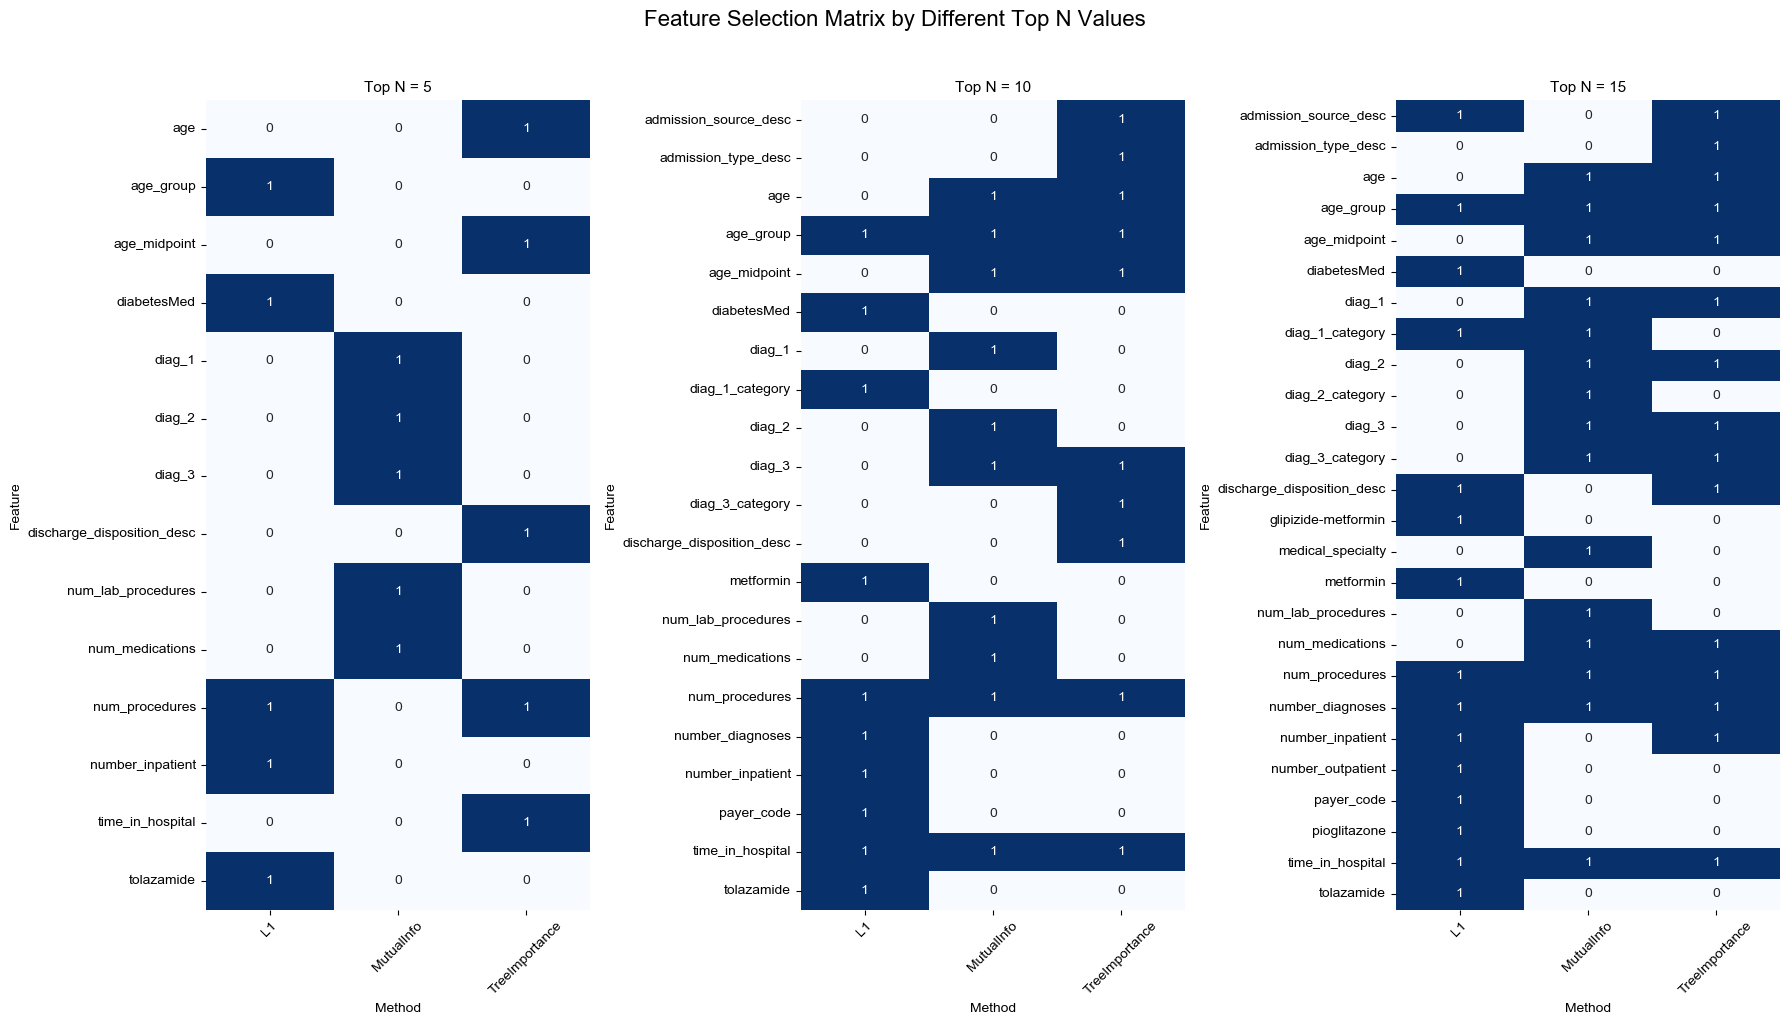

In [18]:

# 4. 以表格形式显示结果
selector.display_multiple_topn_results(multiple_results)

# 5. [新增] 可视化特征选择矩阵
selector.plot_feature_selection_matrix(multiple_results)

# ============

# 6. Model training and evaluation

In [19]:
# here is the defalt setting of model taining
# # 查阅model_trainer.py的get_models()方法，你当前的模型参数是默认的，具体如下：
# •	LogisticRegression:
# •	solver='liblinear'
# •	random_state=42
# •	其余参数默认（如C=1.0）
# •	RandomForestClassifier:
# •	n_estimators=100
# •	random_state=42
# •	其余参数默认（如max_depth=None）
# •	XGBoost (XGBClassifier):
# •	eval_metric='logloss'
# •	random_state=42
# •	其余参数默认（如n_estimators=100, learning_rate=0.3）
# 没有做超参数调优（grid search），只是用了一组固定参数。


# feature_selectors = selector.get_feature_selectors() 

# feature_sets = {}
# for top_n in top_n_list:
#     feature_sets[top_n] = {}
#     for fs_name, fs_func in feature_selectors.items():
#         features = fs_func(X_train_balanced, y_train_balanced, top_n=top_n)
#         feature_sets[top_n][fs_name] = features
           
# model_trainer = ModelTrainer()
# results_df = model_trainer.evaluate_all_combinations_on_val_and_test(
#     feature_sets, X_train, y_train, X_val, y_val, X_test, y_test
# )
# display(results_df)


In [20]:
print(df.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'discharge_disposition_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type_desc', 'discharge_disposition_desc',
       'admission_source_desc', 'age_midpoint', 'age_group', 'diag_1_category',
       'diag_2_category', 'diag_3_category'

In [21]:
# 导入必要的包
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd
import os

# 设置参数（这些保留在notebook中便于修改）
fs_names = ['L1', 'MutualInfo', 'TreeImportance']
top_n = 15
cv_folds = 5  # 可以改成5

# 定义模型和参数网格
model_classes = {
    'LogisticRegression': LogisticRegression,
    'RandomForest': RandomForestClassifier,
    
    'XGBoost': XGBClassifier
}

# # 精简版本 第一次
param_grids = {
    
    'LogisticRegression': {
        'C': [ 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2'],
        'max_iter': [1000]
    },
    'RandomForest': {
        'n_estimators': [100, 500],
        'max_depth': [None,  10, 20],
        'min_samples_split': [2,  10],
        'min_samples_leaf': [1,  4]

    },
    'XGBoost': {
        'n_estimators': [100, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3,  7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8,  1.0]
    }
}



# 第二次调参

# param_grids = {
#     'RandomForest': {
#     'n_estimators': [400, 500, 600],
#     'max_depth': [None, 20, 30, 40],
#     'min_samples_split': [2, 3, 5],
#     'min_samples_leaf': [1, 2, 3]
#     },
#     'LogisticRegression': {
#     'C': [0.05, 0.1, 0.2, 0.5, 1],
#     'solver': ['liblinear', 'saga'],
#     'penalty': ['l1'],
#     'max_iter': [1000]
#     },
#     'XGBoost': {
#     'n_estimators': [100, 300],
#     'learning_rate': [0.05, 0.07, 0.13],
#     'max_depth': [6,  8],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     # 'reg_alpha': [0, 0.1],
#     # 'reg_lambda': [0]
#     }
# }

# # 第三次调参 取消，因为发现第二次的不如第一次的好
# param_grids = {
#     'RandomForest': {
#     'n_estimators': [500, 550, 600, 650],
#     'max_depth': [25, 30, 35, None],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1]
#     },
#     'LogisticRegression': {
#     'C': [0.01, 0.03, 0.05, 0.07, 0.1],
#     'solver': ['liblinear'],
#     'penalty': ['l1'],
#     'max_iter': [1000]
#     },
#     'XGBoost': {
#     'n_estimators': [200, 250,300],
#     'learning_rate': [ 0.04, 0.05, 0.06, 0.07],
#     'max_depth': [7,10],
#     'subsample': [0.8, 0.9],
#     'colsample_bytree': [ 0.8, 0.85, 0.9],
#     'reg_alpha': [0, 0.1],
#     'reg_lambda': [0,0.1]
#     }
# }


In [22]:

# 调用py文件中的方法
model_trainer = ModelTrainer()
all_val_results, all_test_results, all_cv_results_list = model_trainer.run_grid_search_for_all_fs_methods(
    fs_names=fs_names,
    top_n=top_n,
    selected_features_dict=selected_features_dict,
    model_classes=model_classes,
    param_grids=param_grids,
    X_train_balanced=X_train_balanced,
    y_train_balanced=y_train_balanced,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    cv_folds=cv_folds
)

# 保存到Excel（这部分保留在notebook中便于修改）
excel_path = ' comorbidity2_all_param_search_results_gridcv.xlsx'
mode = 'a' if os.path.exists(excel_path) else 'w'

with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
    for i, fs_name in enumerate(fs_names):
        val_df = all_val_results[i]
        test_df = all_test_results[i]
        cv_df = all_cv_results_list[i]
        
        val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
        test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
        cv_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)
        
        print(f"{fs_name} 结果已保存到 {excel_path}")

print("所有GridSearchCV结果已保存完成！")


Grid search for L1 - LogisticRegression ...
Best params: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

Grid search for L1 - RandomForest ...
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Grid search for L1 - XGBoost ...
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
L1 GridSearchCV completed

Grid search for MutualInfo - LogisticRegression ...
Best params: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

Grid search for MutualInfo - RandomForest ...
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Grid search for MutualInfo - XGBoost ...
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
MutualInfo GridSearchCV completed

Grid search for TreeImportance - LogisticRegression ...
Best params: {'C': 0.1, 'ma

## L1

In [23]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'L1'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")

## MutualInfo

In [24]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'MutualInfo'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")

## TreeImportance

In [25]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'TreeImportance'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")